In [36]:
import joblib
from tensorflow.keras.models import load_model
import nfl_data_py as nfl
import pandas as pd
import os
import numpy as np
import urllib.request
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnnotationBbox, OffsetImage
import matplotlib.image as mpimg
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
import seaborn as sns


In [2]:
booster = xgb.Booster()
booster.load_model("../models/xgb_final_model.json")

In [3]:
df_twofour = nfl.import_pbp_data([2024], downcast=True, cache=False, alt_path=None, include_participation=False)

#regular season data only
df_twofour = df_twofour.loc[df_twofour.season_type=='REG']

'''
The below line removes kick offs, field goals, kneels, etc - only plays with passes, runs, and penalties, and we're going to leave it out because it can impact max scores
'''
#df_twofour = df_twofour.loc[(df_twofour.play_type.isin(['no_play','pass','run'])) & (df_twofour.epa.isna()==False)]

#match play call to play type, so QB scrambles still considered pass plays
df_twofour.loc[df_twofour['pass']==1, 'play_type'] = 'pass'
df_twofour.loc[df_twofour.rush==1, 'play_type'] = 'run'

#reset index to skip missing numbers
df_twofour.reset_index(drop=True, inplace=True)

df_twofour.head()

2024 done.
Downcasting floats.


,play_id,game_id,old_game_id,home_team,away_team,season_type,week,posteam,posteam_type,defteam,...,out_of_bounds,home_opening_kickoff,qb_epa,xyac_epa,xyac_mean_yardage,xyac_median_yardage,xyac_success,xyac_fd,xpass,pass_oe
0,1.0,2024_01_ARI_BUF,2024090801,BUF,ARI,REG,1,None,None,None,...,0.0,0.0,-0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,40.0,2024_01_ARI_BUF,2024090801,BUF,ARI,REG,1,ARI,away,BUF,...,0.0,0.0,0.257819,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,61.0,2024_01_ARI_BUF,2024090801,BUF,ARI,REG,1,ARI,away,BUF,...,0.0,0.0,-0.200602,NaN,NaN,NaN,NaN,NaN,0.456761,-45.676102
3,83.0,2024_01_ARI_BUF,2024090801,BUF,ARI,REG,1,ARI,away,BUF,...,0.0,0.0,2.028874,1.345418,9.321221,8.0,0.509778,0.363807,0.576656,42.334431
4,108.0,2024_01_ARI_BUF,2024090801,BUF,ARI,REG,1,ARI,away,BUF,...,0.0,0.0,0.754242,0.882798,5.783560,4.0,0.668478,0.255140,0.426443,57.355690


In [4]:
team_off_stats = df_twofour[['game_id', 'home_team', 'away_team', 'posteam', 'epa', 'pass_length', 'air_yards', 'air_epa', 'yac_epa', 'comp_air_epa', 'comp_yac_epa', 'yards_gained', 'total_home_rush_epa', 'total_away_rush_epa', 'total_home_pass_epa', 'total_away_pass_epa']]

team_off_stats

,game_id,home_team,away_team,posteam,epa,pass_length,air_yards,air_epa,yac_epa,comp_air_epa,comp_yac_epa,yards_gained,total_home_rush_epa,total_away_rush_epa,total_home_pass_epa,total_away_pass_epa
0,2024_01_ARI_BUF,BUF,ARI,None,-0.000000,None,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000
1,2024_01_ARI_BUF,BUF,ARI,ARI,0.257819,None,NaN,NaN,NaN,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
2,2024_01_ARI_BUF,BUF,ARI,ARI,-0.200602,None,NaN,NaN,NaN,0.000000,0.000000,3.0,0.200602,-0.200602,0.000000,0.000000
3,2024_01_ARI_BUF,BUF,ARI,ARI,2.028874,short,-3.0,-1.083852,3.112726,-1.083852,3.112726,22.0,0.200602,-0.200602,-2.028874,2.028874
4,2024_01_ARI_BUF,BUF,ARI,ARI,0.754242,short,2.0,-0.567367,1.321609,-0.567367,1.321609,9.0,0.200602,-0.200602,-2.783116,2.783116
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47269,2024_18_WAS_DAL,DAL,WAS,None,-0.000000,None,NaN,NaN,NaN,0.000000,0.000000,0.0,-6.516163,6.516163,2.221897,-2.221897
47270,2024_18_WAS_DAL,DAL,WAS,WAS,3.690094,short,5.0,3.690094,0.000000,3.690094,0.000000,5.0,-6.516163,6.516163,-1.468198,1.468198
47271,2024_18_WAS_DAL,DAL,WAS,WAS,0.068571,None,NaN,NaN,NaN,0.000000,0.000000,0.0,-6.516163,6.516163,-1.468198,1.468198
47272,2024_18_WAS_DAL,DAL,WAS,DAL,-0.021433,None,NaN,NaN,NaN,0.000000,0.000000,0.0,-6.516163,6.516163,-1.468198,1.468198


In [5]:

home_off_stats = (
    team_off_stats.groupby([
        'game_id', 'posteam', 'home_team'], as_index=False)
    .agg({        
                
        'air_yards': 'sum',
        'air_epa': 'mean',
        'yac_epa': 'mean',
        'yards_gained': 'mean',
        'total_home_rush_epa': 'last',
        'total_home_pass_epa': 'last'
        
    })
)

home_off_stats = home_off_stats[home_off_stats['posteam'] == home_off_stats['home_team']]

home_off_stats = home_off_stats[['game_id', 'home_team', 'air_yards', 'air_epa', 'yac_epa', 'yards_gained', 'total_home_rush_epa', 'total_home_pass_epa']]

home_off_stats

,game_id,home_team,air_yards,air_epa,yac_epa,yards_gained,total_home_rush_epa,total_home_pass_epa
1,2024_01_ARI_BUF,BUF,166.0,0.434981,0.246898,4.400000,-1.487240,10.345948
3,2024_01_BAL_KC,KC,165.0,0.225717,0.267809,5.191176,-8.339071,12.255391
5,2024_01_CAR_NO,NO,208.0,0.440537,-0.069503,4.737500,10.038772,25.839762
6,2024_01_DAL_CLE,CLE,395.0,0.470844,-0.760778,2.371134,3.963566,-16.448318
9,2024_01_DEN_SEA,SEA,167.0,0.152016,-0.249091,3.619048,1.712284,15.118529
...,...,...,...,...,...,...,...,...
535,2024_18_NO_TB,TB,258.0,0.823625,-0.500669,4.702381,3.531472,10.484469
537,2024_18_NYG_PHI,PHI,270.0,0.290206,-0.005745,3.695122,-12.487288,16.192055
538,2024_18_SEA_LA,LA,221.0,0.170221,0.047322,5.037500,-3.371261,-7.761229
540,2024_18_SF_ARI,ARI,223.0,0.203110,0.025771,4.678571,9.089952,4.701149


In [6]:
'''
add rush and pass epa for home
'''

pass_epa_home = (
    df_twofour[
        (df_twofour['pass'] == 1) &
        (df_twofour['posteam'] == df_twofour['home_team'])
    ]
    .groupby(['game_id', 'home_team'])['epa']
    .mean()
    .reset_index()
    .rename(columns={'epa': 'pass_epa',
                    })
)


rush_epa_home = (
    df_twofour[
        (df_twofour['rush'] == 1) &
        (df_twofour['posteam'] == df_twofour['home_team'])
    ]
    .groupby(['game_id', 'home_team'])['epa']
    .mean()
    .reset_index()
    .rename(columns={'epa': 'rush_epa',
                   })
)

merged_home_epa = pd.merge(pass_epa_home, rush_epa_home, on = ["game_id", "home_team"], how = "inner")

merged_home_epa


,game_id,home_team,pass_epa,rush_epa
0,2024_01_ARI_BUF,BUF,0.530074,-0.152609
1,2024_01_BAL_KC,KC,0.418001,-0.206895
2,2024_01_CAR_NO,NO,0.341233,0.108933
3,2024_01_DAL_CLE,CLE,-0.364576,-0.066941
4,2024_01_DEN_SEA,SEA,-0.055301,-0.079800
...,...,...,...,...
267,2024_18_NO_TB,TB,0.389386,-0.163374
268,2024_18_NYG_PHI,PHI,0.174808,-0.426006
269,2024_18_SEA_LA,LA,0.044681,-0.023251
270,2024_18_SF_ARI,ARI,0.311485,0.245257


In [7]:

mgd_home_off_stats = pd.merge(home_off_stats, merged_home_epa, on = ["game_id", "home_team"], how = "inner")
mgd_home_off_stats["is_home"]=1

mgd_home_off_stats = (
        mgd_home_off_stats.rename(columns={
            'game_id': 'Game ID',
            'home_team': 'Team',
            'total_home_rush_epa': 'tot_rush_epa',
            'total_home_pass_epa': 'tot_pass_epa'
        })
    )

mgd_home_off_stats


,Game ID,Team,air_yards,air_epa,yac_epa,yards_gained,tot_rush_epa,tot_pass_epa,pass_epa,rush_epa,is_home
0,2024_01_ARI_BUF,BUF,166.0,0.434981,0.246898,4.400000,-1.487240,10.345948,0.530074,-0.152609,1
1,2024_01_BAL_KC,KC,165.0,0.225717,0.267809,5.191176,-8.339071,12.255391,0.418001,-0.206895,1
2,2024_01_CAR_NO,NO,208.0,0.440537,-0.069503,4.737500,10.038772,25.839762,0.341233,0.108933,1
3,2024_01_DAL_CLE,CLE,395.0,0.470844,-0.760778,2.371134,3.963566,-16.448318,-0.364576,-0.066941,1
4,2024_01_DEN_SEA,SEA,167.0,0.152016,-0.249091,3.619048,1.712284,15.118529,-0.055301,-0.079800,1
...,...,...,...,...,...,...,...,...,...,...,...
267,2024_18_NO_TB,TB,258.0,0.823625,-0.500669,4.702381,3.531472,10.484469,0.389386,-0.163374,1
268,2024_18_NYG_PHI,PHI,270.0,0.290206,-0.005745,3.695122,-12.487288,16.192055,0.174808,-0.426006,1
269,2024_18_SEA_LA,LA,221.0,0.170221,0.047322,5.037500,-3.371261,-7.761229,0.044681,-0.023251,1
270,2024_18_SF_ARI,ARI,223.0,0.203110,0.025771,4.678571,9.089952,4.701149,0.311485,0.245257,1


In [8]:
away_off_stats = (
    team_off_stats.groupby([
        'game_id', 'posteam', 'away_team'], as_index=False)
    .agg({        
               
        'air_yards': 'sum',
        'air_epa': 'mean',
        'yac_epa': 'mean',
        'yards_gained': 'mean',
        'total_away_rush_epa': 'last',
        'total_away_pass_epa': 'last'
        
    })
)

away_off_stats = away_off_stats[away_off_stats['posteam'] == away_off_stats['away_team']]

away_off_stats = away_off_stats[['game_id', 'away_team', 'air_yards', 'air_epa', 'yac_epa', 'yards_gained', 'total_away_rush_epa', 'total_away_pass_epa']]

away_off_stats

,game_id,away_team,air_yards,air_epa,yac_epa,yards_gained,total_away_rush_epa,total_away_pass_epa
0,2024_01_ARI_BUF,ARI,191.0,0.264410,-0.002161,3.675676,1.487240,-10.345948
2,2024_01_BAL_KC,BAL,267.0,0.283028,-0.207785,4.860215,9.331709,-13.575565
4,2024_01_CAR_NO,CAR,383.0,1.103341,-1.498585,2.506494,-12.997964,-26.460785
7,2024_01_DAL_CLE,DAL,290.0,0.236065,-0.321842,3.192771,-3.963566,16.448318
8,2024_01_DEN_SEA,DEN,264.0,0.272864,-0.741811,2.510870,-2.932473,-15.457881
...,...,...,...,...,...,...,...,...
534,2024_18_NO_TB,NO,370.0,0.570054,-0.529343,3.560976,-3.531472,-11.079356
536,2024_18_NYG_PHI,NYG,106.0,-0.152756,-0.146393,3.500000,12.487288,-16.192055
539,2024_18_SEA_LA,SEA,215.0,0.323960,0.205319,4.732394,3.371261,7.761229
541,2024_18_SF_ARI,SF,335.0,0.515233,-0.329818,4.688172,-10.304694,-4.701149


In [9]:
pass_epa_away = (
    df_twofour[
        (df_twofour['pass'] == 1) &
        (df_twofour['posteam'] == df_twofour['away_team'])
    ]
    .groupby(['game_id', 'away_team'])['epa']
    .mean()
    .reset_index()
    .rename(columns={'epa': 'pass_epa',
                     
                    })
)

rush_epa_away = (
    df_twofour[
        (df_twofour['rush'] == 1) &
        (df_twofour['posteam'] == df_twofour['away_team'])
    ]
    .groupby(['game_id', 'away_team'])['epa']
    .mean()
    .reset_index()
    .rename(columns={'epa': 'rush_epa',
                    })
)

merged_away_epa = pd.merge(pass_epa_away, rush_epa_away, on = ["game_id", "away_team"], how = "inner")
merged_away_epa

,game_id,away_team,pass_epa,rush_epa
0,2024_01_ARI_BUF,ARI,0.158981,-0.101872
1,2024_01_BAL_KC,BAL,-0.044366,0.259507
2,2024_01_CAR_NO,CAR,-0.335719,-0.768481
3,2024_01_DAL_CLE,DAL,-0.166446,-0.009678
4,2024_01_DEN_SEA,DEN,-0.358542,-0.194789
...,...,...,...,...
267,2024_18_NO_TB,NO,0.032712,-0.050440
268,2024_18_NYG_PHI,NYG,-0.299149,0.090526
269,2024_18_SEA_LA,SEA,0.327962,0.144192
270,2024_18_SF_ARI,SF,0.046621,-0.087529


In [10]:
mgd_away_off_stats = pd.merge(away_off_stats, merged_away_epa, on = ["game_id", "away_team"], how = "inner")

mgd_away_off_stats["is_home"]=0

mgd_away_off_stats = (
        mgd_away_off_stats.rename(columns={
            'total_away_rush_epa': 'tot_rush_epa',
            'total_away_pass_epa': 'tot_pass_epa',
            'game_id': 'Game ID',
            'away_team': 'Team'
        })
    )

mgd_away_off_stats

,Game ID,Team,air_yards,air_epa,yac_epa,yards_gained,tot_rush_epa,tot_pass_epa,pass_epa,rush_epa,is_home
0,2024_01_ARI_BUF,ARI,191.0,0.264410,-0.002161,3.675676,1.487240,-10.345948,0.158981,-0.101872,0
1,2024_01_BAL_KC,BAL,267.0,0.283028,-0.207785,4.860215,9.331709,-13.575565,-0.044366,0.259507,0
2,2024_01_CAR_NO,CAR,383.0,1.103341,-1.498585,2.506494,-12.997964,-26.460785,-0.335719,-0.768481,0
3,2024_01_DAL_CLE,DAL,290.0,0.236065,-0.321842,3.192771,-3.963566,16.448318,-0.166446,-0.009678,0
4,2024_01_DEN_SEA,DEN,264.0,0.272864,-0.741811,2.510870,-2.932473,-15.457881,-0.358542,-0.194789,0
...,...,...,...,...,...,...,...,...,...,...,...
267,2024_18_NO_TB,NO,370.0,0.570054,-0.529343,3.560976,-3.531472,-11.079356,0.032712,-0.050440,0
268,2024_18_NYG_PHI,NYG,106.0,-0.152756,-0.146393,3.500000,12.487288,-16.192055,-0.299149,0.090526,0
269,2024_18_SEA_LA,SEA,215.0,0.323960,0.205319,4.732394,3.371261,7.761229,0.327962,0.144192,0
270,2024_18_SF_ARI,SF,335.0,0.515233,-0.329818,4.688172,-10.304694,-4.701149,0.046621,-0.087529,0


In [11]:
   
def_epa_rush_home = (
    df_twofour[(df_twofour['rush'] == 1) & (df_twofour['home_team'] ==df_twofour['defteam'])].groupby([
        'game_id', 'defteam', 'home_team'], as_index=False)
    .agg({        
        'epa': 'mean'
  
    })
)



def_epa_rush_home = (def_epa_rush_home.rename(
    columns={
            'game_id': 'Game ID',
            'home_team': 'Team',
            'epa': "Def Rush EPA"
        })
    )

def_epa_rush_home.drop(columns=['defteam'], inplace=True)

def_epa_rush_home

,Game ID,Team,Def Rush EPA
0,2024_01_ARI_BUF,BUF,-0.101872
1,2024_01_BAL_KC,KC,0.259507
2,2024_01_CAR_NO,NO,-0.768481
3,2024_01_DAL_CLE,CLE,-0.009678
4,2024_01_DEN_SEA,SEA,-0.194789
...,...,...,...
267,2024_18_NO_TB,TB,-0.050440
268,2024_18_NYG_PHI,PHI,0.090526
269,2024_18_SEA_LA,LA,0.144192
270,2024_18_SF_ARI,ARI,-0.087529


In [12]:
def_epa_rush_away = (
    df_twofour[(df_twofour['rush'] == 1) & (df_twofour['away_team'] == df_twofour['defteam'])].groupby([
        'game_id', 'defteam', 'away_team'], as_index=False)
    .agg({        
        'epa': 'mean'
  
    })
)

def_epa_rush_away = (def_epa_rush_away.rename(
    columns={
            'game_id': 'Game ID',
            'away_team': 'Team',
            'epa': "Def Rush EPA"
        })
    )

def_epa_rush_away.drop(columns=['defteam'], inplace=True)

def_epa_rush_away

,Game ID,Team,Def Rush EPA
0,2024_01_ARI_BUF,ARI,-0.152609
1,2024_01_BAL_KC,BAL,-0.206895
2,2024_01_CAR_NO,CAR,0.108933
3,2024_01_DAL_CLE,DAL,-0.066941
4,2024_01_DEN_SEA,DEN,-0.079800
...,...,...,...
267,2024_18_NO_TB,NO,-0.163374
268,2024_18_NYG_PHI,NYG,-0.426006
269,2024_18_SEA_LA,SEA,-0.023251
270,2024_18_SF_ARI,SF,0.245257


In [13]:

def_epa_pass_home = (
    df_twofour[(df_twofour['pass'] == 1) & (df_twofour['home_team'] == df_twofour['defteam'])].groupby([
        'game_id', 'defteam', 'home_team'], as_index=False)
    .agg({        
        'epa': 'mean'
  
    })
)

def_epa_pass_home = (def_epa_pass_home.rename(
    columns={
            'game_id': 'Game ID',
            'home_team': 'Team',
            'epa': "Def Pass EPA"
        })
    )

def_epa_pass_home.drop(columns=['defteam'], inplace=True)

def_epa_pass_home

,Game ID,Team,Def Pass EPA
0,2024_01_ARI_BUF,BUF,0.158981
1,2024_01_BAL_KC,KC,-0.044366
2,2024_01_CAR_NO,NO,-0.335719
3,2024_01_DAL_CLE,CLE,-0.166446
4,2024_01_DEN_SEA,SEA,-0.358542
...,...,...,...
267,2024_18_NO_TB,TB,0.032712
268,2024_18_NYG_PHI,PHI,-0.299149
269,2024_18_SEA_LA,LA,0.327962
270,2024_18_SF_ARI,ARI,0.046621


In [14]:

def_epa_pass_away = (
    df_twofour[(df_twofour['pass'] == 1) & (df_twofour['away_team'] == df_twofour['defteam'])].groupby([
        'game_id', 'defteam', 'away_team'], as_index=False)
    .agg({        
        'epa': 'mean'
  
    })
)

def_epa_pass_away = (def_epa_pass_away.rename(
    columns={
            'game_id': 'Game ID',
            'away_team': 'Team',
            'epa': "Def Pass EPA"
        })
    )

def_epa_pass_away.drop(columns=['defteam'], inplace=True)

def_epa_pass_away

,Game ID,Team,Def Pass EPA
0,2024_01_ARI_BUF,ARI,0.530074
1,2024_01_BAL_KC,BAL,0.418001
2,2024_01_CAR_NO,CAR,0.341233
3,2024_01_DAL_CLE,DAL,-0.364576
4,2024_01_DEN_SEA,DEN,-0.055301
...,...,...,...
267,2024_18_NO_TB,NO,0.389386
268,2024_18_NYG_PHI,NYG,0.174808
269,2024_18_SEA_LA,SEA,0.044681
270,2024_18_SF_ARI,SF,0.311485


In [15]:

def_stats_home = df_twofour[['game_id', 'defteam','home_team', 'epa', 'interception', 'fumble_forced', 'tackled_for_loss', 'sack', 'qb_hit']] 


def_stats_home = (
    def_stats_home[(df_twofour['home_team'] == df_twofour['defteam'])].groupby([
        'game_id', 'defteam', 'home_team'], as_index=False)
    .agg({
        'interception': 'sum',
        'fumble_forced': 'sum',
        'tackled_for_loss': 'sum',
        'sack': 'sum',
        'qb_hit': 'sum'})
)


def_stats_home = (def_stats_home.rename(
    columns={
            'game_id': 'Game ID',
            'home_team': 'Team'            
        })
    )

def_stats_home.drop(columns=['defteam'], inplace=True)

def_stats_home   

,Game ID,Team,interception,fumble_forced,tackled_for_loss,sack,qb_hit
0,2024_01_ARI_BUF,BUF,0.0,1.0,1.0,4.0,5.0
1,2024_01_BAL_KC,KC,0.0,1.0,1.0,1.0,1.0
2,2024_01_CAR_NO,NO,2.0,1.0,1.0,4.0,5.0
3,2024_01_DAL_CLE,CLE,0.0,1.0,2.0,3.0,4.0
4,2024_01_DEN_SEA,SEA,2.0,2.0,3.0,2.0,8.0
...,...,...,...,...,...,...,...
267,2024_18_NO_TB,TB,0.0,0.0,4.0,2.0,6.0
268,2024_18_NYG_PHI,PHI,1.0,0.0,0.0,0.0,2.0
269,2024_18_SEA_LA,LA,0.0,0.0,2.0,2.0,3.0
270,2024_18_SF_ARI,ARI,2.0,4.0,2.0,2.0,4.0


In [16]:
def_stats_away = df_twofour[['game_id', 'defteam','away_team', 'epa', 'interception', 'fumble_forced', 'tackled_for_loss', 'sack', 'qb_hit']] 


def_stats_away = (
    def_stats_away[(df_twofour['away_team'] == df_twofour['defteam'])].groupby([
        'game_id', 'defteam', 'away_team'], as_index=False)
    .agg({
        'interception': 'sum',
        'fumble_forced': 'sum',
        'tackled_for_loss': 'sum',
        'sack': 'sum',
        'qb_hit': 'sum'})
)


def_stats_away = (def_stats_away.rename(
    columns={
            'game_id': 'Game ID',
            'away_team': 'Team'            
        })
    )

def_stats_away.drop(columns=['defteam'], inplace=True)

def_stats_away   

,Game ID,Team,interception,fumble_forced,tackled_for_loss,sack,qb_hit
0,2024_01_ARI_BUF,ARI,0.0,1.0,4.0,2.0,3.0
1,2024_01_BAL_KC,BAL,1.0,0.0,1.0,2.0,6.0
2,2024_01_CAR_NO,CAR,0.0,0.0,3.0,1.0,1.0
3,2024_01_DAL_CLE,DAL,2.0,1.0,1.0,6.0,17.0
4,2024_01_DEN_SEA,DEN,1.0,0.0,5.0,2.0,7.0
...,...,...,...,...,...,...,...
267,2024_18_NO_TB,NO,1.0,0.0,3.0,1.0,1.0
268,2024_18_NYG_PHI,NYG,0.0,0.0,3.0,2.0,7.0
269,2024_18_SEA_LA,SEA,1.0,0.0,0.0,3.0,9.0
270,2024_18_SF_ARI,SF,0.0,0.0,2.0,0.0,2.0


In [17]:
merged_home_df = pd.merge(def_epa_rush_home, def_epa_pass_home, on = ["Game ID", "Team"], how = "inner")

merged_home_df = pd.merge(merged_home_df, def_stats_home, on = ["Game ID", "Team"], how = "inner")

#merged_home_df["is_home"]=1

merged_home_df

,Game ID,Team,Def Rush EPA,Def Pass EPA,interception,fumble_forced,tackled_for_loss,sack,qb_hit
0,2024_01_ARI_BUF,BUF,-0.101872,0.158981,0.0,1.0,1.0,4.0,5.0
1,2024_01_BAL_KC,KC,0.259507,-0.044366,0.0,1.0,1.0,1.0,1.0
2,2024_01_CAR_NO,NO,-0.768481,-0.335719,2.0,1.0,1.0,4.0,5.0
3,2024_01_DAL_CLE,CLE,-0.009678,-0.166446,0.0,1.0,2.0,3.0,4.0
4,2024_01_DEN_SEA,SEA,-0.194789,-0.358542,2.0,2.0,3.0,2.0,8.0
...,...,...,...,...,...,...,...,...,...
267,2024_18_NO_TB,TB,-0.050440,0.032712,0.0,0.0,4.0,2.0,6.0
268,2024_18_NYG_PHI,PHI,0.090526,-0.299149,1.0,0.0,0.0,0.0,2.0
269,2024_18_SEA_LA,LA,0.144192,0.327962,0.0,0.0,2.0,2.0,3.0
270,2024_18_SF_ARI,ARI,-0.087529,0.046621,2.0,4.0,2.0,2.0,4.0


In [18]:
merged_away_df = pd.merge(def_epa_rush_away, def_epa_pass_away, on = ["Game ID", "Team"], how = "inner")

merged_away_df = pd.merge(merged_away_df, def_stats_away, on = ["Game ID", "Team"], how = "inner")

#merged_away_df["is_home"]=0

merged_away_df

,Game ID,Team,Def Rush EPA,Def Pass EPA,interception,fumble_forced,tackled_for_loss,sack,qb_hit
0,2024_01_ARI_BUF,ARI,-0.152609,0.530074,0.0,1.0,4.0,2.0,3.0
1,2024_01_BAL_KC,BAL,-0.206895,0.418001,1.0,0.0,1.0,2.0,6.0
2,2024_01_CAR_NO,CAR,0.108933,0.341233,0.0,0.0,3.0,1.0,1.0
3,2024_01_DAL_CLE,DAL,-0.066941,-0.364576,2.0,1.0,1.0,6.0,17.0
4,2024_01_DEN_SEA,DEN,-0.079800,-0.055301,1.0,0.0,5.0,2.0,7.0
...,...,...,...,...,...,...,...,...,...
267,2024_18_NO_TB,NO,-0.163374,0.389386,1.0,0.0,3.0,1.0,1.0
268,2024_18_NYG_PHI,NYG,-0.426006,0.174808,0.0,0.0,3.0,2.0,7.0
269,2024_18_SEA_LA,SEA,-0.023251,0.044681,1.0,0.0,0.0,3.0,9.0
270,2024_18_SF_ARI,SF,0.245257,0.311485,0.0,0.0,2.0,0.0,2.0


In [19]:
merged_home_df = (merged_home_df.rename(
    columns={
            'Team': 'Opp_Team',
            'interception': 'o_ints',
            'fumble_forced': 'o_forced_fumble',
            'tackled_for_loss': 'o_tac_for_loss',
            'sack': 'o_sacks',
                    
        })
    )

merged_home_df


,Game ID,Opp_Team,Def Rush EPA,Def Pass EPA,o_ints,o_forced_fumble,o_tac_for_loss,o_sacks,qb_hit
0,2024_01_ARI_BUF,BUF,-0.101872,0.158981,0.0,1.0,1.0,4.0,5.0
1,2024_01_BAL_KC,KC,0.259507,-0.044366,0.0,1.0,1.0,1.0,1.0
2,2024_01_CAR_NO,NO,-0.768481,-0.335719,2.0,1.0,1.0,4.0,5.0
3,2024_01_DAL_CLE,CLE,-0.009678,-0.166446,0.0,1.0,2.0,3.0,4.0
4,2024_01_DEN_SEA,SEA,-0.194789,-0.358542,2.0,2.0,3.0,2.0,8.0
...,...,...,...,...,...,...,...,...,...
267,2024_18_NO_TB,TB,-0.050440,0.032712,0.0,0.0,4.0,2.0,6.0
268,2024_18_NYG_PHI,PHI,0.090526,-0.299149,1.0,0.0,0.0,0.0,2.0
269,2024_18_SEA_LA,LA,0.144192,0.327962,0.0,0.0,2.0,2.0,3.0
270,2024_18_SF_ARI,ARI,-0.087529,0.046621,2.0,4.0,2.0,2.0,4.0


In [20]:
merged_away_df = (merged_away_df.rename(
    columns={
            
            'Team': 'Opp_Team',
            'interception': 'o_ints',
            'fumble_forced': 'o_forced_fumble',
            'tackled_for_loss': 'o_tac_for_loss',
            'sack': 'o_sacks',
                    
        })
    )



merged_away_df

,Game ID,Opp_Team,Def Rush EPA,Def Pass EPA,o_ints,o_forced_fumble,o_tac_for_loss,o_sacks,qb_hit
0,2024_01_ARI_BUF,ARI,-0.152609,0.530074,0.0,1.0,4.0,2.0,3.0
1,2024_01_BAL_KC,BAL,-0.206895,0.418001,1.0,0.0,1.0,2.0,6.0
2,2024_01_CAR_NO,CAR,0.108933,0.341233,0.0,0.0,3.0,1.0,1.0
3,2024_01_DAL_CLE,DAL,-0.066941,-0.364576,2.0,1.0,1.0,6.0,17.0
4,2024_01_DEN_SEA,DEN,-0.079800,-0.055301,1.0,0.0,5.0,2.0,7.0
...,...,...,...,...,...,...,...,...,...
267,2024_18_NO_TB,NO,-0.163374,0.389386,1.0,0.0,3.0,1.0,1.0
268,2024_18_NYG_PHI,NYG,-0.426006,0.174808,0.0,0.0,3.0,2.0,7.0
269,2024_18_SEA_LA,SEA,-0.023251,0.044681,1.0,0.0,0.0,3.0,9.0
270,2024_18_SF_ARI,SF,0.245257,0.311485,0.0,0.0,2.0,0.0,2.0


In [21]:
merged_home_nums = pd.merge(mgd_home_off_stats, merged_away_df, on = ["Game ID"], how = "inner")

merged_home_nums

,Game ID,Team,air_yards,air_epa,yac_epa,yards_gained,tot_rush_epa,tot_pass_epa,pass_epa,rush_epa,is_home,Opp_Team,Def Rush EPA,Def Pass EPA,o_ints,o_forced_fumble,o_tac_for_loss,o_sacks,qb_hit
0,2024_01_ARI_BUF,BUF,166.0,0.434981,0.246898,4.400000,-1.487240,10.345948,0.530074,-0.152609,1,ARI,-0.152609,0.530074,0.0,1.0,4.0,2.0,3.0
1,2024_01_BAL_KC,KC,165.0,0.225717,0.267809,5.191176,-8.339071,12.255391,0.418001,-0.206895,1,BAL,-0.206895,0.418001,1.0,0.0,1.0,2.0,6.0
2,2024_01_CAR_NO,NO,208.0,0.440537,-0.069503,4.737500,10.038772,25.839762,0.341233,0.108933,1,CAR,0.108933,0.341233,0.0,0.0,3.0,1.0,1.0
3,2024_01_DAL_CLE,CLE,395.0,0.470844,-0.760778,2.371134,3.963566,-16.448318,-0.364576,-0.066941,1,DAL,-0.066941,-0.364576,2.0,1.0,1.0,6.0,17.0
4,2024_01_DEN_SEA,SEA,167.0,0.152016,-0.249091,3.619048,1.712284,15.118529,-0.055301,-0.079800,1,DEN,-0.079800,-0.055301,1.0,0.0,5.0,2.0,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
267,2024_18_NO_TB,TB,258.0,0.823625,-0.500669,4.702381,3.531472,10.484469,0.389386,-0.163374,1,NO,-0.163374,0.389386,1.0,0.0,3.0,1.0,1.0
268,2024_18_NYG_PHI,PHI,270.0,0.290206,-0.005745,3.695122,-12.487288,16.192055,0.174808,-0.426006,1,NYG,-0.426006,0.174808,0.0,0.0,3.0,2.0,7.0
269,2024_18_SEA_LA,LA,221.0,0.170221,0.047322,5.037500,-3.371261,-7.761229,0.044681,-0.023251,1,SEA,-0.023251,0.044681,1.0,0.0,0.0,3.0,9.0
270,2024_18_SF_ARI,ARI,223.0,0.203110,0.025771,4.678571,9.089952,4.701149,0.311485,0.245257,1,SF,0.245257,0.311485,0.0,0.0,2.0,0.0,2.0


In [22]:
merged_away_nums = pd.merge(mgd_away_off_stats, merged_home_df, on = ["Game ID"], how = "inner")

merged_away_nums

,Game ID,Team,air_yards,air_epa,yac_epa,yards_gained,tot_rush_epa,tot_pass_epa,pass_epa,rush_epa,is_home,Opp_Team,Def Rush EPA,Def Pass EPA,o_ints,o_forced_fumble,o_tac_for_loss,o_sacks,qb_hit
0,2024_01_ARI_BUF,ARI,191.0,0.264410,-0.002161,3.675676,1.487240,-10.345948,0.158981,-0.101872,0,BUF,-0.101872,0.158981,0.0,1.0,1.0,4.0,5.0
1,2024_01_BAL_KC,BAL,267.0,0.283028,-0.207785,4.860215,9.331709,-13.575565,-0.044366,0.259507,0,KC,0.259507,-0.044366,0.0,1.0,1.0,1.0,1.0
2,2024_01_CAR_NO,CAR,383.0,1.103341,-1.498585,2.506494,-12.997964,-26.460785,-0.335719,-0.768481,0,NO,-0.768481,-0.335719,2.0,1.0,1.0,4.0,5.0
3,2024_01_DAL_CLE,DAL,290.0,0.236065,-0.321842,3.192771,-3.963566,16.448318,-0.166446,-0.009678,0,CLE,-0.009678,-0.166446,0.0,1.0,2.0,3.0,4.0
4,2024_01_DEN_SEA,DEN,264.0,0.272864,-0.741811,2.510870,-2.932473,-15.457881,-0.358542,-0.194789,0,SEA,-0.194789,-0.358542,2.0,2.0,3.0,2.0,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
267,2024_18_NO_TB,NO,370.0,0.570054,-0.529343,3.560976,-3.531472,-11.079356,0.032712,-0.050440,0,TB,-0.050440,0.032712,0.0,0.0,4.0,2.0,6.0
268,2024_18_NYG_PHI,NYG,106.0,-0.152756,-0.146393,3.500000,12.487288,-16.192055,-0.299149,0.090526,0,PHI,0.090526,-0.299149,1.0,0.0,0.0,0.0,2.0
269,2024_18_SEA_LA,SEA,215.0,0.323960,0.205319,4.732394,3.371261,7.761229,0.327962,0.144192,0,LA,0.144192,0.327962,0.0,0.0,2.0,2.0,3.0
270,2024_18_SF_ARI,SF,335.0,0.515233,-0.329818,4.688172,-10.304694,-4.701149,0.046621,-0.087529,0,ARI,-0.087529,0.046621,2.0,4.0,2.0,2.0,4.0


In [23]:
infer_df = pd.concat([merged_home_nums, merged_away_nums], ignore_index=True)

infer_df

,Game ID,Team,air_yards,air_epa,yac_epa,yards_gained,tot_rush_epa,tot_pass_epa,pass_epa,rush_epa,is_home,Opp_Team,Def Rush EPA,Def Pass EPA,o_ints,o_forced_fumble,o_tac_for_loss,o_sacks,qb_hit
0,2024_01_ARI_BUF,BUF,166.0,0.434981,0.246898,4.400000,-1.487240,10.345948,0.530074,-0.152609,1,ARI,-0.152609,0.530074,0.0,1.0,4.0,2.0,3.0
1,2024_01_BAL_KC,KC,165.0,0.225717,0.267809,5.191176,-8.339071,12.255391,0.418001,-0.206895,1,BAL,-0.206895,0.418001,1.0,0.0,1.0,2.0,6.0
2,2024_01_CAR_NO,NO,208.0,0.440537,-0.069503,4.737500,10.038772,25.839762,0.341233,0.108933,1,CAR,0.108933,0.341233,0.0,0.0,3.0,1.0,1.0
3,2024_01_DAL_CLE,CLE,395.0,0.470844,-0.760778,2.371134,3.963566,-16.448318,-0.364576,-0.066941,1,DAL,-0.066941,-0.364576,2.0,1.0,1.0,6.0,17.0
4,2024_01_DEN_SEA,SEA,167.0,0.152016,-0.249091,3.619048,1.712284,15.118529,-0.055301,-0.079800,1,DEN,-0.079800,-0.055301,1.0,0.0,5.0,2.0,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
539,2024_18_NO_TB,NO,370.0,0.570054,-0.529343,3.560976,-3.531472,-11.079356,0.032712,-0.050440,0,TB,-0.050440,0.032712,0.0,0.0,4.0,2.0,6.0
540,2024_18_NYG_PHI,NYG,106.0,-0.152756,-0.146393,3.500000,12.487288,-16.192055,-0.299149,0.090526,0,PHI,0.090526,-0.299149,1.0,0.0,0.0,0.0,2.0
541,2024_18_SEA_LA,SEA,215.0,0.323960,0.205319,4.732394,3.371261,7.761229,0.327962,0.144192,0,LA,0.144192,0.327962,0.0,0.0,2.0,2.0,3.0
542,2024_18_SF_ARI,SF,335.0,0.515233,-0.329818,4.688172,-10.304694,-4.701149,0.046621,-0.087529,0,ARI,-0.087529,0.046621,2.0,4.0,2.0,2.0,4.0


In [24]:
#This step should be avoided, as it will make the inference data a season's total vice how the model was trained (on a by game basis)

'''
infer_set = infer_df.groupby(['Team']).agg({
    'air_yards': 'sum',      
    'air_epa': 'mean',
    'yac_epa': 'mean',
    'yards_gained': 'mean',
    'tot_rush_epa': 'mean',
    'tot_pass_epa': 'mean',
    'pass_epa': 'mean',
    'rush_epa': 'mean',
    'Def Rush EPA': 'sum',
    'Def Pass EPA': 'sum',
    'o_ints': 'sum',
    'o_forced_fumble': 'sum',
    'o_tac_for_loss': 'sum',
    'o_sacks': 'sum',
    'qb_hit': 'sum'
    
}).reset_index()

infer_set.head()'''

"\ninfer_set = infer_df.groupby(['Team']).agg({\n    'air_yards': 'sum',      \n    'air_epa': 'mean',\n    'yac_epa': 'mean',\n    'yards_gained': 'mean',\n    'tot_rush_epa': 'mean',\n    'tot_pass_epa': 'mean',\n    'pass_epa': 'mean',\n    'rush_epa': 'mean',\n    'Def Rush EPA': 'sum',\n    'Def Pass EPA': 'sum',\n    'o_ints': 'sum',\n    'o_forced_fumble': 'sum',\n    'o_tac_for_loss': 'sum',\n    'o_sacks': 'sum',\n    'qb_hit': 'sum'\n    \n}).reset_index()\n\ninfer_set.head()"

In [25]:
home_team = 'CIN'
away_team = 'TEN'

home_inputs = infer_df[infer_df['Team'] == home_team]
away_inputs = infer_df[infer_df['Team'] == away_team]

In [26]:
print(home_inputs)

             Game ID Team  air_yards   air_epa   yac_epa  yards_gained  \
11    2024_01_NE_CIN  CIN      162.0 -0.036369 -0.164932      3.733333   
47   2024_03_WAS_CIN  CIN      283.0  0.612934 -0.100972      5.736842   
65   2024_05_BAL_CIN  CIN      322.0  0.534969  0.199057      4.988764   
121  2024_08_PHI_CIN  CIN      297.0  0.160703 -0.055264      4.000000   
132   2024_09_LV_CIN  CIN      206.0  0.414697 -0.185299      4.054348   
190  2024_13_PIT_CIN  CIN      226.0  0.219204  0.177475      4.573171   
225  2024_16_CLE_CIN  CIN      245.0  0.678049 -0.194573      4.657143   
245  2024_17_DEN_CIN  CIN      343.0  0.454126  0.030155      4.798077   
291   2024_02_CIN_KC  CIN      225.0  0.736538 -0.380741      4.050633   
321  2024_04_CIN_CAR  CIN      172.0  0.352795 -0.062854      4.548780   
353  2024_06_CIN_NYG  CIN      156.0  0.125069  0.036382      4.750000   
366  2024_07_CIN_CLE  CIN      262.0  0.582251 -0.421535      3.140845   
412  2024_10_CIN_BAL  CIN      488.0  

In [27]:
booster = xgb.Booster()

booster.load_model("/Users/kevinstrouse/Desktop/nfl_conda_files/nfl_score_predictor/models/xgb_final_model.json")

features = [
    'air_yards', 'air_epa', 'yac_epa', 'yards_gained',
    'tot_rush_epa', 'tot_pass_epa',
    'Def Rush EPA', 'Def Pass EPA', 'pass_epa', 'rush_epa', 'o_ints', 'o_forced_fumble',
    'o_tac_for_loss', 'o_sacks', 'qb_hit', 'is_home'
]


# Prepare home and away inputs
X_home = infer_df[infer_df['Team'] == home_team].copy()
X_away = infer_df[infer_df['Team'] == away_team].copy()

X_home['is_home'] = 1
X_away['is_home'] = 0

X_home_input = X_home[features]
X_away_input = X_away[features]

# Convert to DMatrix (no scaling)
d_home = xgb.DMatrix(X_home_input, feature_names=features)
d_away = xgb.DMatrix(X_away_input, feature_names=features)

# Predict
home_pred = booster.predict(d_home)
away_pred = booster.predict(d_away)

print(f"{home_team} predicted score: {home_pred[0]:.2f}")
print(f"{away_team} predicted score: {away_pred[0]:.2f}")


CIN predicted score: 16.54
TEN predicted score: 17.91


In [28]:
'''
setting the below aside for now while I work with the model
'''

'\nsetting the below aside for now while I work with the model\n'

In [32]:
'''trying to add on monte carlo simulation'''



'trying to add on monte carlo simulation'

In [33]:
def monte_carlo_predict(booster, team_input_df, features, n_simulations=1000, noise_pct=0.05):
    preds = []

    for _ in range(n_simulations):
        simulated_df = team_input_df.copy()

        # Apply small Gaussian noise to simulate input uncertainty
        noise = np.random.normal(loc=0.0, scale=noise_pct, size=simulated_df[features].shape)
        simulated_df[features] = simulated_df[features] * (1 + noise)

        dmatrix = xgb.DMatrix(simulated_df[features], feature_names=features)
        pred = booster.predict(dmatrix)
        preds.append(pred[0])  # assume one row (one team)

    return np.array(preds)

In [34]:
# Generate Monte Carlo prediction distributions
home_sim_preds = monte_carlo_predict(booster, X_home_input, features)
away_sim_preds = monte_carlo_predict(booster, X_away_input, features)

# Report prediction percentiles
print(f"{home_team} score prediction (10th/50th/90th percentiles): {np.percentile(home_sim_preds, [10, 50, 90])}")
print(f"{away_team} score prediction (10th/50th/90th percentiles): {np.percentile(away_sim_preds, [10, 50, 90])}")

CIN score prediction (10th/50th/90th percentiles): [15.05837355 15.78328609 16.85192299]
TEN score prediction (10th/50th/90th percentiles): [16.47827263 17.18018532 17.85018368]


🏈 CIN win probability: 6.80%
🏈 TEN win probability: 93.20%


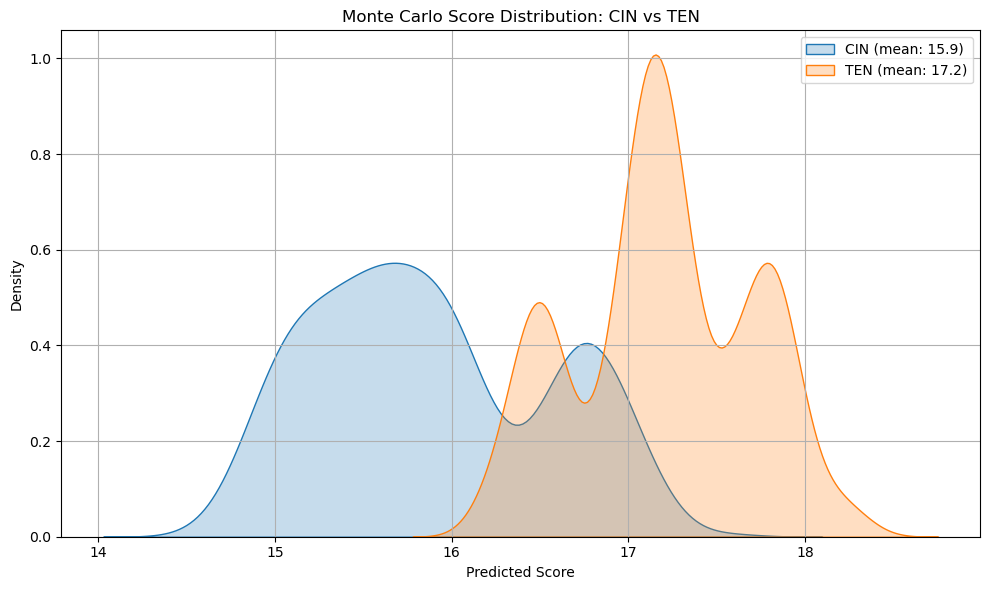

In [37]:
#win probabilities
home_win_prob = np.mean(home_sim_preds > away_sim_preds)
away_win_prob = 1 - home_win_prob
print(f"🏈 {home_team} win probability: {home_win_prob:.2%}")
print(f"🏈 {away_team} win probability: {away_win_prob:.2%}")

#distributions
plt.figure(figsize=(10, 6))
sns.kdeplot(home_sim_preds, label=f"{home_team} (mean: {home_sim_preds.mean():.1f})", fill=True)
sns.kdeplot(away_sim_preds, label=f"{away_team} (mean: {away_sim_preds.mean():.1f})", fill=True)
plt.title(f"Monte Carlo Score Distribution: {home_team} vs {away_team}")
plt.xlabel("Predicted Score")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()